In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV

## Creating historical data csv from 10 tables

- Can ignore and just read in "historical_data_predictive_model.csv"
- Used regular and advanced season stats for the last 5 years

In [105]:
def process_year(year, champion_team):
    
    regular_df = pd.read_csv(f'reg_{year}.csv', header=1)
    regular_df = regular_df.rename(columns={'Unnamed: 1': 'Team'})
    advanced_df = pd.read_csv(f'adv_{year}.csv', header=1)
    advanced_df = advanced_df.rename(columns={'Unnamed: 1': 'Team'})

    data = pd.merge(advanced_df, regular_df, on='Team', suffixes=('_adv', '_reg'))

    data['Stanley_Cup_Champion'] = 0
    data.loc[data['Team'] == champion_team, 'Stanley_Cup_Champion'] = 1
    data['Year'] = year

    return data

In [106]:
years = range(2017, 2023)
champions = ['Pittsburgh Penguins*', 'Washington Capitals*', 'St. Louis Blues*', 'Tampa Bay Lightning*', 'Tampa Bay Lightning*', 'Colorado Avalanche*']
historical_data = pd.concat([process_year(year, champion) for year, champion in zip(years, champions)], ignore_index=True)
historical_data

,Rk_adv,Team,S%_adv,SV%_adv,PDO,CF,CA,CF%,FF,FA,...,SHA,PIM/G,oPIM/G,S,S%_reg,SA,SV%_reg,SO,Stanley_Cup_Champion,Year
0,1,Washington Capitals*,8.4,0.941,102.5,3658,3405,51.8,2696,2546,...,3,9.1,8.7,2495,10.5,2282,0.922,12,0,2017
1,2,Pittsburgh Penguins*,7.9,0.932,101.0,3810,3788,50.1,2874,2735,...,7,8.6,9.0,2745,10.1,2671,0.914,5,1,2017
2,3,Chicago Blackhawks*,7.6,0.937,101.3,3779,3713,50.4,2713,2716,...,7,7.1,7.9,2508,9.6,2574,0.918,4,0,2017
3,4,Columbus Blue Jackets*,7.6,0.936,101.2,3719,3677,50.3,2772,2727,...,2,8.7,8.6,2540,9.7,2489,0.922,8,0,2017
4,5,Minnesota Wild*,8.4,0.931,101.5,3650,3744,49.4,2769,2778,...,3,8.2,8.4,2527,10.4,2465,0.916,5,0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,28,New Jersey Devils,8.0,0.905,98.6,3801,3734,50.4,2888,2874,...,14,8.1,8.4,2562,9.6,2540,0.881,2,0,2022
182,29,Philadelphia Flyers,7.6,0.919,99.5,3403,3895,46.6,2564,2921,...,11,9.0,9.0,2539,8.3,2785,0.894,1,0,2022
183,30,Seattle Kraken,7.5,0.908,98.3,3508,3415,50.7,2615,2593,...,7,8.5,8.0,2380,8.9,2367,0.880,3,0,2022
184,31,Arizona Coyotes,8.6,0.910,99.7,3118,3977,43.9,2346,3052,...,4,10.2,8.2,2121,9.7,2910,0.894,1,0,2022


In [125]:
historical_data.to_csv('historical_data_predictive_model.csv', index=False)

## Averaging multiple random seeds

- When averaging multiple random seeds the correct team is predicted

In [119]:
data = historical_data

teams = data['Team']

data = data.drop(columns=['Team'])

X = data.drop(columns=['Stanley_Cup_Champion', 'Year'])
y = data['Stanley_Cup_Champion']

train_data = data[data['Year'] < 2022]
X_train = train_data.drop(columns=['Stanley_Cup_Champion', 'Year'])
y_train = train_data['Stanley_Cup_Champion']

data_2022 = data[data['Year'] == 2022]
X_2022 = data_2022.drop(columns=['Stanley_Cup_Champion', 'Year'])

team_prob_dict = {}
feature_importances_list = []

for random_seed in range(1, 100):

    clf = RandomForestClassifier(n_estimators=100, random_state=random_seed)
    clf.fit(X_train, y_train)

    feature_importances_list.append(clf.feature_importances_) 

    team_probabilities = clf.predict_proba(X_2022)[:, 1] 
    
    for team, prob in zip(teams[data_2022.index], team_probabilities):
        if team not in team_prob_dict:
            team_prob_dict[team] = [prob]
        else:
            team_prob_dict[team].append(prob)

team_mean_prob_dict = {team: np.mean(probs) for team, probs in team_prob_dict.items()}

sorted_team_probs = sorted(team_mean_prob_dict.items(), key=lambda x: x[1], reverse=True)

for team, prob in sorted_team_probs:
    print(f"{team}: {prob:.2%}")

average_feature_importances = np.mean(feature_importances_list, axis=0)
sorted_indices = np.argsort(average_feature_importances)[::-1]

feature_names = X.columns

print("Top 10 Most Important Predictors:")
for f in range(10):
    print("%d. %s (%f)" % (f+1, feature_names[sorted_indices[f]], average_feature_importances[sorted_indices[f]]))

sorted_team_names, sorted_team_probs = zip(*sorted_team_probs)


Colorado Avalanche*: 36.82%
Florida Panthers*: 36.62%
Minnesota Wild*: 35.20%
Tampa Bay Lightning*: 34.93%
Carolina Hurricanes*: 31.61%
Calgary Flames*: 29.32%
St. Louis Blues*: 28.93%
Toronto Maple Leafs*: 27.52%
Boston Bruins*: 20.55%
Edmonton Oilers*: 15.99%
Pittsburgh Penguins*: 15.70%
New York Rangers*: 14.62%
Nashville Predators*: 11.69%
Washington Capitals*: 6.77%
Winnipeg Jets: 6.56%
Columbus Blue Jackets: 6.29%
New York Islanders: 5.39%
Los Angeles Kings*: 5.28%
Vegas Golden Knights: 4.85%
New Jersey Devils: 3.81%
Vancouver Canucks: 3.61%
Dallas Stars*: 3.03%
Arizona Coyotes: 2.86%
Philadelphia Flyers: 1.34%
Ottawa Senators: 1.31%
Montreal Canadiens: 0.99%
Anaheim Ducks: 0.92%
Detroit Red Wings: 0.63%
San Jose Sharks: 0.41%
Buffalo Sabres: 0.13%
Chicago Blackhawks: 0.12%
Seattle Kraken: 0.10%
Top 10 Most Important Predictors:
1. HDCO% (0.044350)
2. CA (0.037679)
3. FA (0.037068)
4. HDF (0.032420)
5. PIM/G (0.032187)
6. xGF (0.031298)
7. S%_reg (0.030296)
8. S (0.026237)
9. HDF

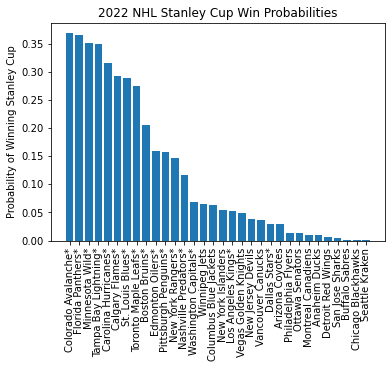

In [122]:
plt.bar(sorted_team_names, sorted_team_probs)
plt.xticks(rotation=90)
plt.ylabel('Probability of Winning Stanley Cup')
plt.title('2022 NHL Stanley Cup Win Probabilities')
plt.show()


## What attributes are most important

In [126]:
historical_data.columns

Index(['Rk_adv', 'Team', 'S%_adv', 'SV%_adv', 'PDO', 'CF', 'CA', 'CF%', 'FF',
       'FA', 'FF%', 'xGF', 'xGA', 'aGF', 'aGA', 'axDiff', 'SCF', 'SCA', 'SCF%',
       'HDF', 'HDA', 'HDF%', 'HDGF', 'HDC%', 'HDGA', 'HDCO%', 'Rk_reg',
       'AvAge', 'GP', 'W', 'L', 'OL', 'PTS', 'PTS%', 'GF', 'GA', 'SOW', 'SOL',
       'SRS', 'SOS', 'GF/G', 'GA/G', 'PP', 'PPO', 'PP%', 'PPA', 'PPOA', 'PK%',
       'SH', 'SHA', 'PIM/G', 'oPIM/G', 'S', 'S%_reg', 'SA', 'SV%_reg', 'SO',
       'Stanley_Cup_Champion', 'Year'],
      dtype='object')

In [123]:
print("Top 10 Most Important Predictors:")
for f in range(10):
    print("%d. %s (%f)" % (f+1, feature_names[sorted_indices[f]], average_feature_importances[sorted_indices[f]]))

Top 10 Most Important Predictors:
1. HDCO% (0.044350)
2. CA (0.037679)
3. FA (0.037068)
4. HDF (0.032420)
5. PIM/G (0.032187)
6. xGF (0.031298)
7. S%_reg (0.030296)
8. S (0.026237)
9. HDF% (0.025253)
10. SCF (0.023193)
